In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
base_dir = '/ix/djishnu/shared/djishnu_kor11/training_data_2025/'
adata = sc.read_h5ad(f'{base_dir}slideseq_mouse_lymphnode.h5ad')


In [5]:
adata_1der = sc.read_h5ad('/ix/djishnu/Yijia/project_asthma_lung/1_slide_tcr_seq/data/slideTCR_asthma_lymphnode_tangramAnno_wTCR_wRegion_w1DERCT_sample1_test.h5ad')
banksy = pd.read_csv('banksy_cluster.csv', index_col=0)
adata.obs['banksy_celltypes'] = banksy['banksy_cluster'].astype(str)

shared = set(adata.obs_names) & set(adata_1der.obs_names)
transferred = adata_1der[adata_1der.obs['1DER'] == True].obs_names
adata.obs['1DER'] = adata.obs_names.isin(transferred)

transferred = adata.obs_names[adata.obs['1DER']].tolist() # some cells were filtered out

adata.obs['1DER_cell_type'] = adata.obs['cell_type'].copy().astype(str)
adata.obs.loc[transferred, '1DER_cell_type'] = adata_1der.obs.loc[transferred, '1DER_cell_type'].astype(str)


In [6]:
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram', 'banksy_celltypes', '1DER', '1DER_cell_type'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
from spaceoracle.models.parallel_estimators import create_spatial_features


2025-06-18 15:30:52.494876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [8]:
spf = create_spatial_features(
    x=adata.obsm['spatial'][:, 0], 
    y=adata.obsm['spatial'][:, 1], 
    celltypes=adata.obs.cell_type, 
    obs_index=adata.obs_names
)


In [18]:
nbrs = {}

for cell_type in adata.obs.cell_type.unique():
    nbrs[cell_type] = spf[adata.obs.cell_type == cell_type]

nbrs['1DER'] =  spf[adata.obs.index.isin(transferred)]

In [19]:
nbrhood_means = {}

for cell_type in nbrs.keys():
    # Convert to numeric values before calculating mean
    nbrhood_means[cell_type] = nbrs[cell_type].astype(float).mean() 

nbrhood_means = {k: v / v.sum() for k, v in nbrhood_means.items()}


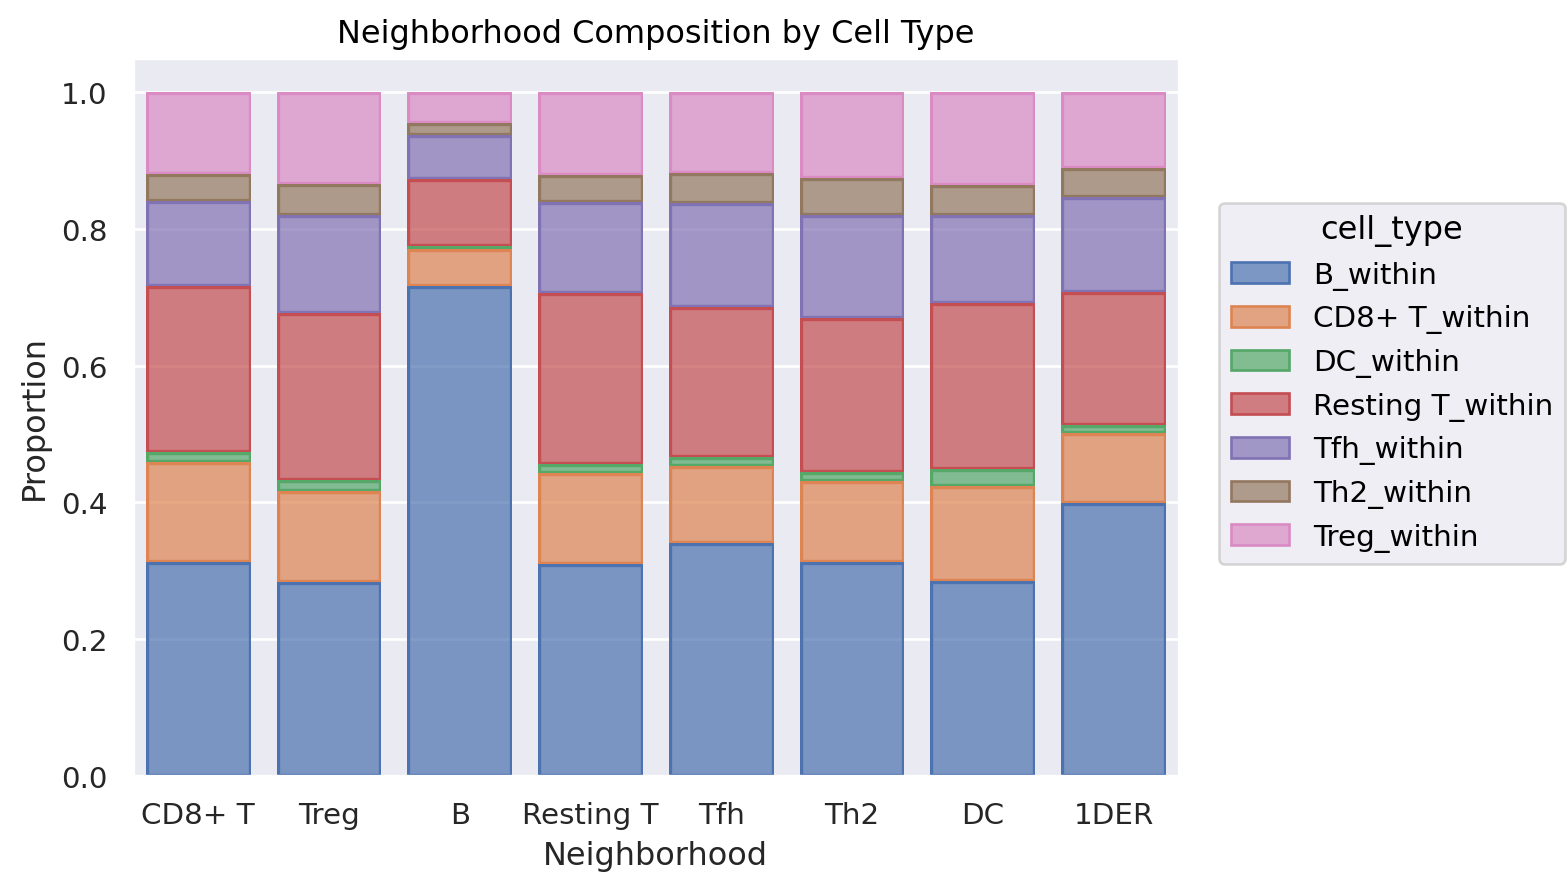

In [33]:
import seaborn.objects as so

# Convert the dictionary to a DataFrame for plotting
plot_data = []
for ct, proportions in nbrhood_means.items():
    for cell_type, prop in proportions.items():
        plot_data.append({
            'cell_type': cell_type,
            'proportion': prop,
            'neighborhood': ct
        })
df = pd.DataFrame(plot_data)

# Create stacked bar plot
(so.Plot(df, x="neighborhood", y="proportion", color="cell_type")
 .add(so.Bar(), so.Stack())
 .label(title="Neighborhood Composition by Cell Type", 
        x="Neighborhood", 
        y="Proportion")
#  .show()
 )